# Attempts to implement MF on Movielens Dataset

In [1]:
import sys
sys.path.extend(['../../matrix-factorization'])

In [2]:
import numpy as np
import pandas as pd

from src.data import Dataset

In [3]:
dataset = Dataset('../movielens-20m-dataset/rating.csv', n_most_users=1000, m_most_items=200)

In [4]:
dataset.dataset['userIdOrdered'] = dataset.dataset['userId'].astype('category').cat.codes
dataset.dataset['movieIdOrdered'] = dataset.dataset['movieId'].astype('category').cat.codes

In [5]:
train_dataset, test_dataset = dataset.split_dataset(0.2)

In [6]:
train_dataset

,userId,movieId,rating,timestamp,userIdOrdered,movieIdOrdered
41027,32984,1210,4.0,2002-06-13 07:28:38,245,104
161319,133133,2997,5.0,2006-09-05 17:07:52,966,167
67373,54447,2997,4.5,2005-08-03 18:02:49,402,167
96329,78356,260,4.5,2010-08-27 17:17:35,575,31
13711,10560,586,3.0,2005-06-18 03:41:40,81,64
...,...,...,...,...,...,...
27030,21391,8961,4.0,2005-04-15 23:26:03,161,197
39662,32094,7153,4.0,2009-03-04 11:49:03,237,194
109461,89495,1221,5.0,2015-01-30 01:17:36,653,109
161836,133811,2797,3.0,2002-01-11 04:48:00,969,161


In [7]:
M = train_dataset.movieId.nunique()
N = train_dataset.userId.nunique()

In [10]:
items_per_user = train_dataset.groupby("userIdOrdered").apply(
    lambda x: pd.Series({'ratedMovies': dict(zip(x["movieIdOrdered"], x["rating"])),
                         'meanRating': x["rating"].mean()}), include_groups=False)
users_per_item = train_dataset.groupby("movieIdOrdered").apply(
    lambda x: pd.Series({'usersRated': dict(zip(x["userIdOrdered"], x["rating"])),
                         'meanRating': x["rating"].mean()}), include_groups=False)

In [11]:
items_per_user

,ratedMovies,meanRating
userIdOrdered,,
0,"{40: 4.0, 104: 5.0, 146: 5.0, 24: 4.0, 167: 3....",4.381890
1,"{199: 3.5, 61: 4.0, 139: 3.5, 167: 4.5, 66: 4....",3.684615
2,"{43: 4.0, 51: 4.0, 199: 4.0, 121: 4.5, 65: 4.0...",4.003846
3,"{47: 4.5, 156: 4.0, 13: 3.5, 199: 4.0, 48: 5.0...",4.084112
4,"{88: 4.5, 103: 3.5, 10: 4.0, 21: 2.5, 87: 5.0,...",3.626667
...,...,...
995,"{88: 3.5, 65: 3.5, 28: 4.0, 136: 3.0, 167: 3.0...",3.346429
996,"{196: 4.0, 39: 3.0, 33: 3.0, 172: 4.5, 157: 3....",4.139752
997,"{41: 2.0, 15: 5.0, 78: 3.0, 146: 2.0, 93: 3.0,...",3.537190


In [39]:
def train(K):  # K: hyperparameter
    losses = []
    W, U = np.random.randn(N, K), np.random.randn(M, K)
    for t in range(10):
        print(f"Iteration {t + 1}")
        for user_id in items_per_user.index:
            items_rated_user_id = items_per_user.loc[user_id].ratedMovies 
            u = U[list(items_rated_user_id.keys())]
            ratings_w = np.array(list(items_rated_user_id.values()))
            A_w = np.dot(u.T, u)
            b_w = np.dot(ratings_w, u)
            W[user_id] = np.linalg.solve(A_w, b_w)
        for item_id in users_per_item.index:
            users_rated_item_id = users_per_item.loc[item_id].usersRated
            w = W[list(users_rated_item_id.keys())]
            ratings_u = np.array(list(users_rated_item_id.values()))
            A_u = np.dot(w.T, w)
            b_u = np.dot(ratings_u, w)
            U[item_id] = np.linalg.solve(A_u, b_u)
        # Calculate loss function
        loss = 0
        for index, row in train_dataset.iterrows():
            user_id = row['userIdOrdered']
            item_id = row['movieIdOrdered']
            loss += (row["rating"] - np.dot(W[user_id], U[item_id].T)) ** 2
        loss = np.sqrt(loss / len(train_dataset))
        losses.append(loss)
        print(f"Loss for iteration {t + 1}: {loss}")
    return losses

In [40]:
losses = {}
for k in [5, 10, 20, 30, 50, 100]:
    losses[k] = train(k)

Iteration 1
Loss for iteration 1: 1.3191649141643504
Iteration 2
Loss for iteration 2: 0.7254389214901595
Iteration 3
Loss for iteration 3: 0.7170626151831985
Iteration 4
Loss for iteration 4: 0.7150781151235533
Iteration 5
Loss for iteration 5: 0.7141305388158534
Iteration 6
Loss for iteration 6: 0.7134954306282605
Iteration 7
Loss for iteration 7: 0.7130174464714368
Iteration 8
Loss for iteration 8: 0.712645636052736
Iteration 9
Loss for iteration 9: 0.7123554254784153
Iteration 10
Loss for iteration 10: 0.7121306368406489
Iteration 1
Loss for iteration 1: 1.1168993185516203
Iteration 2
Loss for iteration 2: 0.6913042631086727
Iteration 3
Loss for iteration 3: 0.6732583743998002
Iteration 4
Loss for iteration 4: 0.6668710024779825
Iteration 5
Loss for iteration 5: 0.6636698983726268
Iteration 6
Loss for iteration 6: 0.6619550023632726
Iteration 7
Loss for iteration 7: 0.660978360301456
Iteration 8
Loss for iteration 8: 0.6603710882628997
Iteration 9
Loss for iteration 9: 0.6599664712

In [64]:
import matplotlib.pyplot as plt

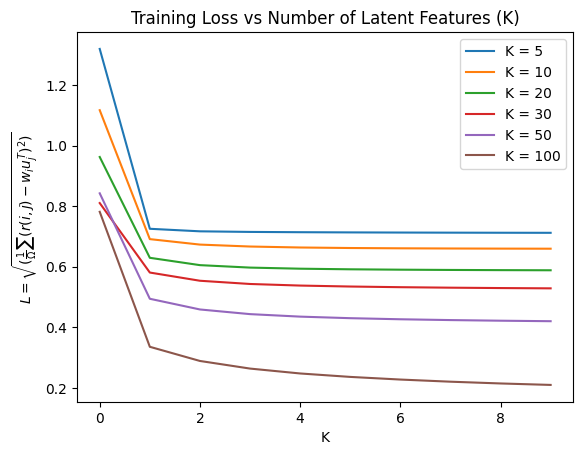

In [65]:
for k in losses.keys():
    plt.plot(losses[k], label=f"K = {k}")
    plt.legend()
plt.title("Training Loss vs Number of Latent Features (K)")
plt.xlabel("K")
plt.ylabel(r"$L = \sqrt{(\frac{1}{\Omega}\sum{(r(i, j) - w_{i}u_{j}^T)^2)}}$")
plt.show()